# Basic Neural Network prediciting one parameter
Now has been rewritten to use JHPY to make it easier to read.

In [1]:
from JHPY import *

In [2]:
outputs = generate_sine_data(data_points=1000, mean=10, std=2)

train_loader = outputs["Train_Loader"]
val_loader = outputs["Val_Loader"]
test_loader = outputs["Test_Loader"]


In [ ]:
param_grid = {
    'lstm_hidden_size': [128, 256],
    'lstm_num_layers': [1],
    'fc_layer_sizes': [[128, 64], [256, 128], [64, 32]],
    'activation': ['relu'],
    'dropout': [0.0],
    'learning_rate': [0.01]
}

best_config, search_results = hyperparameter_search(
    param_grid, 
    train_loader, 
    val_loader, 
    n_epochs=50,
    n_trials=None  # Try 10 random configurations (set to None to try all combinations)
)

print("\nTop 5 configurations:")
for i, result in enumerate(search_results[:5]):
    print(f"\n{i+1}. Val Loss: {result['best_val_loss']:.4f}, R²: {result['best_val_r2']:.4f}")
    print(f"   Config: {result['config']}")

## Train Final Model with Best Configuration

In [ ]:
# Train final model with best configuration found from search
final_model = ParameterPredictor(best_config)
lossfcn = nn.MSELoss()

# Extract learning rate from best_config or use default
lr = best_config.get('learning_rate', 0.01)
final_optimizer = torch.optim.Adam(final_model.parameters(), lr=lr)

final_scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    final_optimizer,
    mode='min',
    factor=0.5,
    patience=4,
    min_lr=1e-6,
)

# Train for more epochs since this is the final model
final_outputs = train_model(
    final_model, 
    final_optimizer, 
    lossfcn, 
    200,  # More epochs for final training
    train_loader, 
    val_loader, 
    patience=10,  # More patience for final model
    scheduler=final_scheduler,
    save_best_model=True,  # Save the best model checkpoint
    model_path='best_final_model.pt'  # Path to save the model
)

# Plot training curves
plt.figure(figsize=(10, 5))
plt.plot(final_outputs['train_losses'], label='Train Loss')
plt.plot(final_outputs['val_losses'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training History (Best Configuration)')
plt.legend()
plt.grid(True)
plt.show()

print(f"\nBest model saved at epoch {final_outputs['best_val_epoch'] + 1} with validation loss {final_outputs['best_val_loss']:.4f}")

# Evaluation

In [3]:
# Load the best saved model for evaluation
eval_model, checkpoint = load_best_model('best_final_model.pt')

# Display the configuration of the loaded model
print("\nModel Configuration:")
for key, value in checkpoint['model_config'].items():
    print(f"  {key}: {value}")

Loaded model from best_final_model.pt
  Best epoch: 200
  Best validation loss: 0.0083

Model Configuration:
  lstm_hidden_size: 128
  lstm_num_layers: 1
  fc_layer_sizes: [128, 64]
  activation: relu
  dropout: 0.0
  learning_rate: 0.01


Test Set Performance (Best Saved Model):
  RMSE: 0.0608
  MAE: 0.0492
  R²: 0.9987


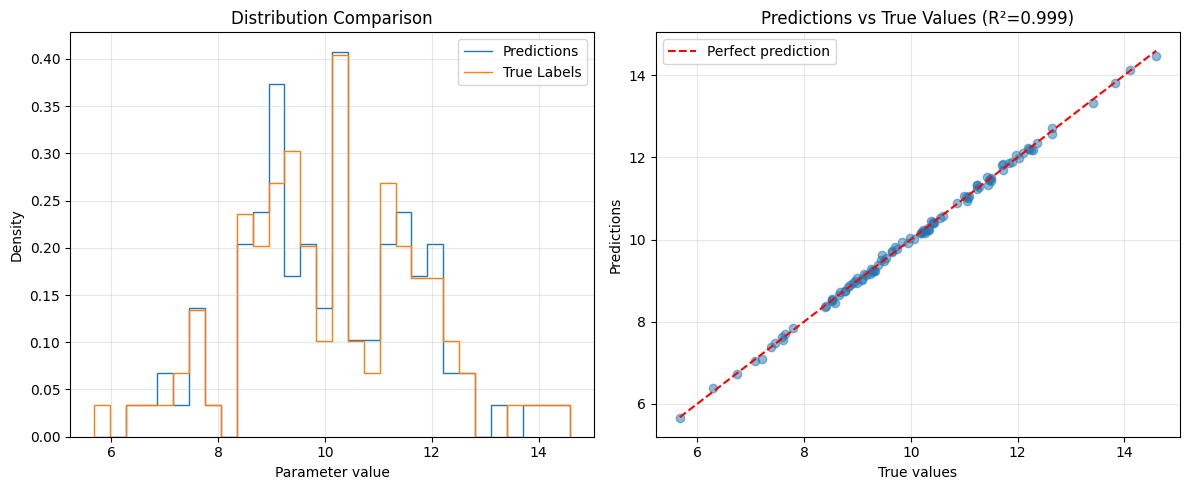

In [4]:
predictions = []
labels = []
rmse_list = []

# Use eval_model (loaded from checkpoint)
eval_model.eval()

for X_test, y_test in test_loader:
    test_predictions = eval_model(X_test).detach().numpy()
    test_targets = y_test.numpy()
    predictions.extend(test_predictions)
    labels.extend(test_targets)
    rmse = np.sqrt(np.mean((test_predictions - test_targets) ** 2))
    rmse_list.append(rmse)

# Calculate overall test metrics
test_metrics = calculate_metrics(np.array(predictions), np.array(labels))

print("Test Set Performance (Best Saved Model):")
print(f"  RMSE: {test_metrics['rmse']:.4f}")
print(f"  MAE: {test_metrics['mae']:.4f}")
print(f"  R²: {test_metrics['r2']:.4f}")

# Plot prediction vs true distribution
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
l_counts, l_edges = np.histogram(labels, bins=30, density=True)
p_counts, p_edges = np.histogram(predictions, bins=l_edges, density=True)  # align bins with predictions
plt.stairs(p_counts, p_edges, label='Predictions', color='C0')
plt.stairs(l_counts, l_edges, label='True Labels', color='C1')
plt.xlabel('Parameter value')
plt.ylabel('Density')
plt.title('Distribution Comparison')
plt.legend()
plt.grid(True, alpha=0.3)

# Plot scatter: predictions vs true values
plt.subplot(1, 2, 2)
plt.scatter(labels, predictions, alpha=0.5)
plt.plot([min(labels), max(labels)], [min(labels), max(labels)], 'r--', label='Perfect prediction')
plt.xlabel('True values')
plt.ylabel('Predictions')
plt.title(f'Predictions vs True Values (R²={test_metrics["r2"]:.3f})')
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()